In [19]:
import os
import numpy as np
import pydicom
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
#from keras.src import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers.schedules import CosineDecay

from keras.callbacks import EarlyStopping

In [6]:

# Paths
image_path_base = r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\png'
text_path_base = r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\myver_cleanCropCMMD.csv'

def get_image_paths_and_labels():
    image_paths = []
    labels = []

    with open(text_path_base) as f:
        f.readline()

        for line in f:
            splitLine = line.split(",")

            imagePath = splitLine[2].replace("\n", "").replace('"',"") 
            image_paths.append(imagePath)

            classification = splitLine[1].replace('"', '') 
            if classification == "0":
              labels.append(np.array([0]))
            if classification == "1":
              labels.append(np.array([1]))


    return np.array(image_paths), np.array(labels)

image_paths, labels = get_image_paths_and_labels()

paths_train, paths_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=1
)

In [7]:
print(len(paths_train))
print(len(paths_test))

4472
1118


In [8]:
class DataGenerator:
    def __init__(self, image_paths, labels, batch_size=32, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.1,
            horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for path in batch_paths:

            img = load_img(path, color_mode='rgb')
            img_array = img_to_array(img)
            img_tensor = tf.convert_to_tensor(img_array)
            img = tf.image.resize_with_pad(img_tensor, 600, 600)
            batch_images.append(img)

        X = np.array(batch_images)
        y = np.array(batch_labels).reshape(-1, 1)

        if self.augment:
            for i in range(len(X)):
                if np.random.random() > 0.5: 
                    X[i] = self.datagen.random_transform(X[i])

        return X, y

    def generate(self):
        while True:
            indices = np.random.permutation(len(self.image_paths))
            self.image_paths = self.image_paths[indices]
            self.labels = self.labels[indices]

            for i in range(len(self)):
                yield self.__getitem__(i)

train_gen = DataGenerator(paths_train, y_train, batch_size=32, augment=True)
test_gen = DataGenerator(paths_test, y_test, batch_size=32, augment=False)


In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Flatten y_train into a 1D array
y_train_labels = y_train.flatten()

print(np.unique(y_train_labels))
print("Class distribution:", np.bincount(y_train_labels)) 

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(zip(np.unique(y_train_labels), class_weights))

print("Class Weights:", class_weight_dict)


[0 1]
Class distribution: [1125 3347]
Class Weights: {0: 1.9875555555555555, 1: 0.6680609501045712}


In [21]:
# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(600, 600, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name='auc')])

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import load_model

# Load best saved weights
model.load_weights(r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model.weights.h5')

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

checkpoint_filepath = r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model_finetuned.weights.h5'
chptpt = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

In [24]:
#unfreeze_more_layers(model, base_model, n_layers=30)

for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy", AUC(name="auc")])


In [25]:
history = model.fit(
    train_gen.generate(),
    steps_per_epoch=len(train_gen),
    validation_data=test_gen.generate(),
    validation_steps=len(test_gen),
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, chptpt]
)

Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 0.7920 - accuracy: 0.6096 - auc: 0.6473
Epoch 1: val_loss improved from inf to 0.85519, saving model to C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model_finetuned.weights.h5
140/140 [==============================] - 997s 7s/step - loss: 0.7920 - accuracy: 0.6096 - auc: 0.6473 - val_loss: 0.8552 - val_accuracy: 0.5242 - val_auc: 0.6729 - lr: 1.0000e-05
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.7580 - accuracy: 0.6342 - auc: 0.6975
Epoch 2: val_loss improved from 0.85519 to 0.79179, saving model to C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model_finetuned.weights.h5
140/140 [==============================] - 1001s 7s/step - loss: 0.7580 - accuracy: 0.6342 - auc: 0.6975 - val_loss: 0.7918 - val_accuracy: 0.6154 - val_auc: 0.6799 - lr: 1.0000

In [26]:
model.save(r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Models\crop_resnet_finetuned.h5')

Finished model

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import load_model

# Load best saved weights
#model.load_weights(r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model.weights.h5')

def evaluate_model(model, generator, steps, model_name="Model"):
    if hasattr(generator, 'on_epoch_end'):
        generator.on_epoch_end()

    y_true = []
    y_pred_prob = []
    
    for i in range(steps):
        if hasattr(generator, '__getitem__'):
            batch_x, batch_y = generator.__getitem__(i)
        else:
            batch_x, batch_y = next(generator.generate())
            
        batch_pred = model.predict(batch_x, verbose=0)
        
        y_true.extend(batch_y)
        y_pred_prob.extend(batch_pred)

    y_true = np.array(y_true).flatten()
    y_pred_prob = np.array(y_pred_prob).flatten()
    
    y_pred = (y_pred_prob > 0.5).astype(int)

    # --- Classification Report ---
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])

    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
    cm_path = fr'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result2_finetuned\finetune_finished_confusion_matrix.png'
    plt.savefig(cm_path)
    print(f"Confusion matrix saved to: {cm_path}")
    plt.close()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    
    roc_path = fr'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result2_finetuned\finetune_finished_roc_curve.png'
    plt.savefig(roc_path)
    print(f"ROC curve saved to: {roc_path}")
    plt.close()

    return {
        'accuracy': (y_pred == y_true).mean(),
        'auc': roc_auc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob,
        'confusion_matrix': cm
    }

results = evaluate_model(model, test_gen, len(test_gen), model_name="Initial_Model")

print(f"\n Final Accuracy: {results['accuracy']:.4f}, AUC: {results['auc']:.4f}")

print("\nConfusion Matrix:")
print(results['confusion_matrix'])


--- Initial_Model Classification Report ---
              precision    recall  f1-score   support

      Benign       0.43      0.49      0.46       291
   Malignant       0.81      0.77      0.79       827

    accuracy                           0.70      1118
   macro avg       0.62      0.63      0.63      1118
weighted avg       0.71      0.70      0.71      1118

Confusion matrix saved to: C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result2_finetuned\finetune_finished_confusion_matrix.png
ROC curve saved to: C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result2_finetuned\finetune_finished_roc_curve.png

 Final Accuracy: 0.6995, AUC: 0.7002

Confusion Matrix:
[[143 148]
 [188 639]]


Best weight

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import load_model

# Load best saved weights
# model.load_weights(r'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\weights\best_model_finetuned.weights.h5')
#print("Best weights loaded for evaluation.")

def evaluate_model(model, generator, steps, model_name="Model"):
    if hasattr(generator, 'on_epoch_end'):
        generator.on_epoch_end()

    y_true = []
    y_pred_prob = []
    
    for i in range(steps):
        if hasattr(generator, '__getitem__'):
            batch_x, batch_y = generator.__getitem__(i)
        else:
            batch_x, batch_y = next(generator.generate())
            
        batch_pred = model.predict(batch_x, verbose=0)
        
        y_true.extend(batch_y)
        y_pred_prob.extend(batch_pred)

    y_true = np.array(y_true).flatten()
    y_pred_prob = np.array(y_pred_prob).flatten()
    
    y_pred = (y_pred_prob > 0.5).astype(int)

    # --- Classification Report ---
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])

    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
    cm_path = fr'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result2_finetuned\finetune_best_confusion_matrix.png'
    plt.savefig(cm_path)
    print(f"Confusion matrix saved to: {cm_path}")
    plt.close()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    
    roc_path = fr'C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result2_finetuned\finetune_best_roc_curve.png'
    plt.savefig(roc_path)
    print(f"ROC curve saved to: {roc_path}")
    plt.close()

    return {
        'accuracy': (y_pred == y_true).mean(),
        'auc': roc_auc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob,
        'confusion_matrix': cm
    }

results = evaluate_model(model, test_gen, len(test_gen), model_name="Initial_Model")

print(f"\n Final Accuracy: {results['accuracy']:.4f}, AUC: {results['auc']:.4f}")

print("\nConfusion Matrix:")
print(results['confusion_matrix'])

Best weights loaded for evaluation.

--- Initial_Model Classification Report ---
              precision    recall  f1-score   support

      Benign       0.43      0.49      0.46       291
   Malignant       0.81      0.77      0.79       827

    accuracy                           0.70      1118
   macro avg       0.62      0.63      0.63      1118
weighted avg       0.71      0.70      0.71      1118

Confusion matrix saved to: C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result2_finetuned\finetune_best_confusion_matrix.png
ROC curve saved to: C:\Users\yaruu\OneDrive\Documents\DIS Copenhagen 2025\Courses\ANN & DL\Final Project\Datasets\CMMD_Clean\result2_finetuned\finetune_best_roc_curve.png

 Final Accuracy: 0.6995, AUC: 0.7002

Confusion Matrix:
[[143 148]
 [188 639]]


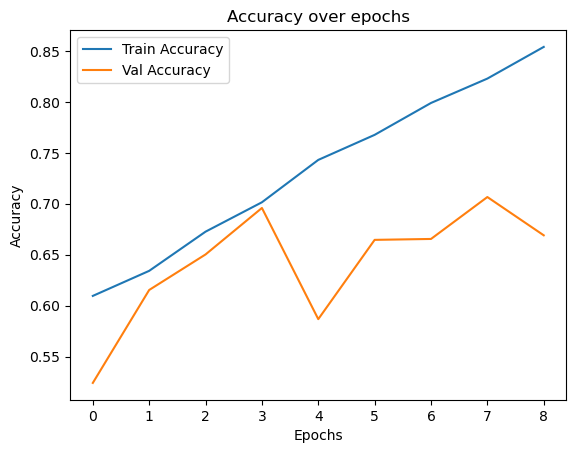

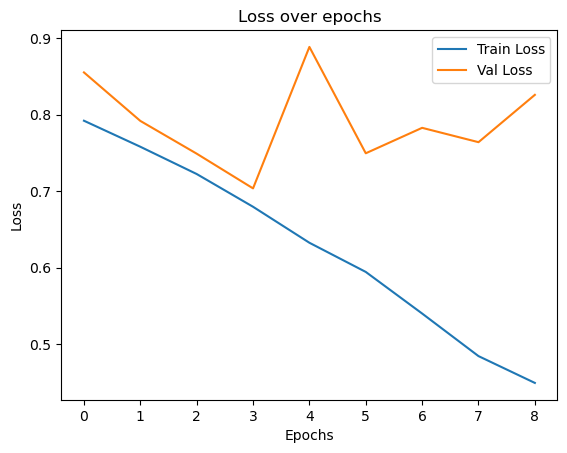

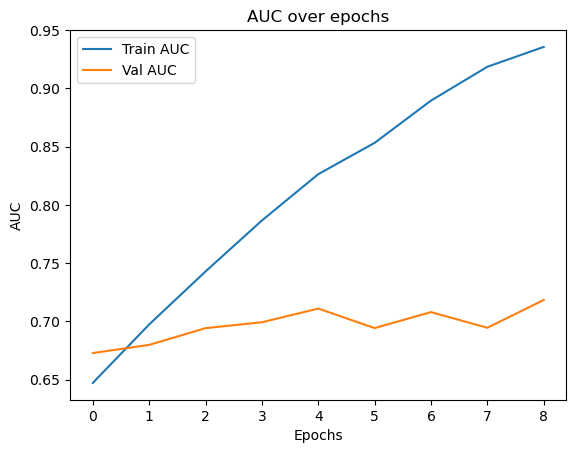

In [30]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot AUC if included in metrics
if 'auc' in history.history:
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('AUC over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.show()
